In [1]:
import pdbufr
import sys
import traceback
 
from math import isnan

import plotly.express as px
from shapely.geometry import LineString

from ipywidgets import interact
import os
import birdy
import geopandas as gpd
import pandas as pd
from datetime import datetime, timedelta
import ipyleaflet
import ipywidgets as widgets

from Magics import macro as magics
from IPython.display import display
from Magics.macro import *

import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to import storms file and load it in a dataframe
def create_storms_df():
    # Load cyclone dataframe with Mean sea level pressure value
    df_storms = pdbufr.read_bufr("trials/track_data/tc_test.bufr",
        columns=("stormIdentifier", "ensembleMemberNumber", "latitude", "longitude",
                 "pressureReducedToMeanSeaLevel"))
    # Load cyclone dataframe with Wind speed at 10m value
    df1 = pdbufr.read_bufr("trials/track_data/tc_test.bufr",
        columns=("stormIdentifier", "ensembleMemberNumber", "latitude", "longitude",
                 "windSpeedAt10M"))
    # Add the Wind speed at 10m column to the storms dataframe 
    df_storms["windSpeedAt10M"] = df1.windSpeedAt10M
    # Storms with number higher than 10 are not real storms (according to what Fernando said)
    drop_condition = df_storms.stormIdentifier < '11'
    df_storms = df_storms[drop_condition]
    return df_storms

df_storms = create_storms_df()
# Drop NaN in latitude and longitude columns
df_storms.dropna(subset = ['latitude', 'longitude'], inplace=True)

In [30]:
## SAVE EACH ENSEMBLE TRACK IN A DIFFERENT .CSV FILE ##

storms = df_storms.stormIdentifier.unique()

for storm in storms:
    df_cyclone = df_storms[df_storms.stormIdentifier == storm]
    
    # create folder for the trajectories of the cyclone
    folder = "data/" + storm + "/"
    try:
        os.makedirs(folder)
    except:
        print(f'Folder {folder} already existing')
    
    # Save .csv file for each ensemble track
    ensembles = df_cyclone.ensembleMemberNumber.unique()
    for ensemble in ensembles:
        filename = folder + 'trajectory_%.02d.csv' % ensemble
        df_track = df_cyclone[df_cyclone.ensembleMemberNumber == ensemble]
        df_track.drop(columns=['stormIdentifier', 'ensembleMemberNumber'], inplace=True)
        df_track.to_csv(filename, index=False)

Folder data/08W/ already existing


In [64]:
## FUNCTION TO PLOT ALL THE ENSEMBLE TRACKS OF A CYCLONE ##
# .csv files must be saved already

def plot_ensemble_tracks(cyclone_n, bottom, up, left, right):
    
    toplot = []
    # settings of the geographical area
    area = mmap(
        subpage_map_projection="cylindrical",
        subpage_lower_left_longitude=left,
        subpage_lower_left_latitude=bottom,
        subpage_upper_right_longitude=right,
        subpage_upper_right_latitude=up,
    )
    toplot.append(area)
    
    # settings of the coastline
    coast = mcoast(
        map_coastline_land_shade = "on",
        map_coastline_land_shade_colour = "cream",
        map_coastline_sea_shade = "on",
        map_coastline_sea_shade_colour = "#70CEE2",
        # map_cities = "on",
        map_grid_line_style = "dash",
        map_grid_colour = "black",
        map_label = "on",
        map_label_colour = "brown",
        map_coastline_colour = "brown",
    )
    toplot.append(coast)
    
    # settings of the tracks 
    colours = ["red", "blue", "green", "yellow", "purple", "orange", "cyan", "black" ]
    colour = 0

    for i in range(1,52):

        file = f"data/{cyclone_n}/trajectory_%02d.csv" % i

        data = mtable(
            table_filename = file,
            table_variable_identifier_type='index',
            table_latitude_variable = "1",
            table_longitude_variable = "2",
            table_value_variable = "3",
            table_header_row = 0,
        )

        line=msymb(
            symbol_type='marker',
            symbol_marker_index = 28,
            symbol_colour = colours[colour],
            symbol_height = 0.20,
            symbol_text_font_colour = "black",       
            symbol_connect_line ='on'
        )

        colour += 1
        if colour == len(colours):
            colour = 0

        toplot.append(data)
        toplot.append(line)
    
    title = mtext(
        text_lines= [f"<font colour='navy'> {cyclone_n} ensemble trajectories </font>"],
        text_justification= 'centre',
        text_font_size= 1.,
        text_font_style= 'bold',
        text_mode='title',
    )
    toplot.append(title)
    
    return toplot

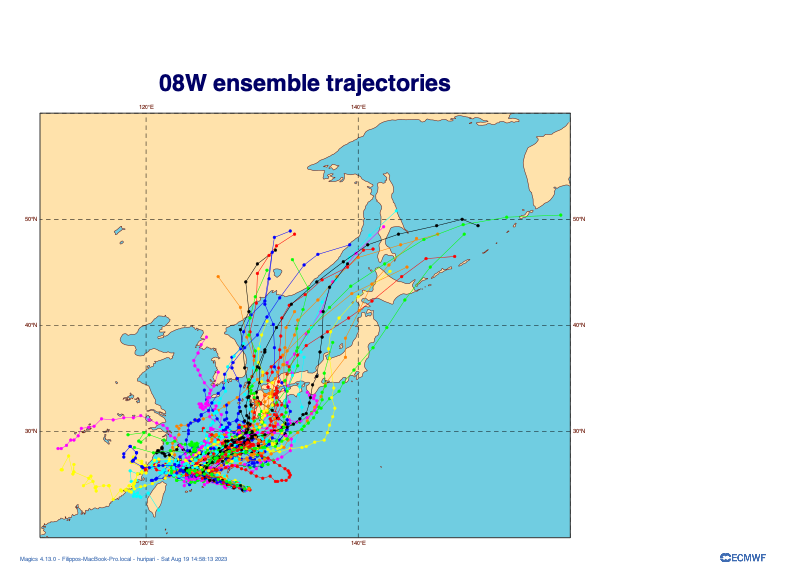

In [65]:
toplot = plot_ensemble_tracks('08W', 20, 60, 110, 160)
plot(toplot)

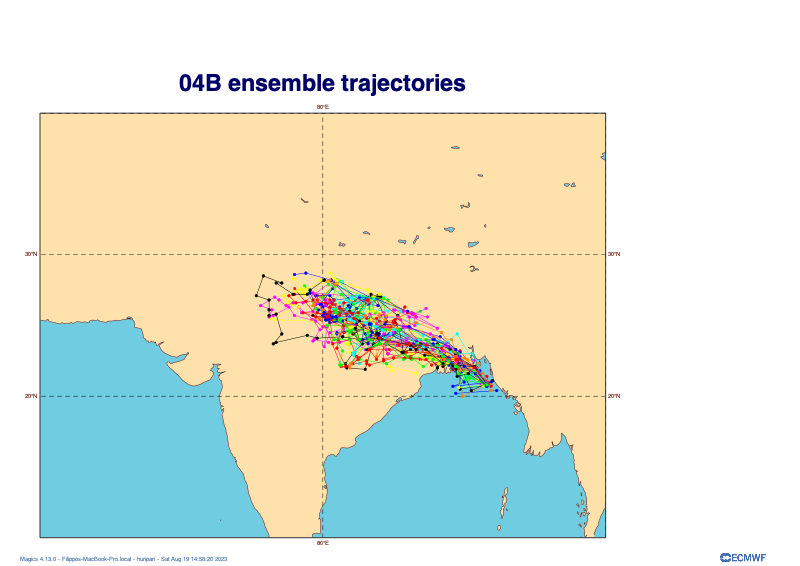

In [66]:
toplot = plot_ensemble_tracks('04B', 10, 40, 60, 100)
plot(toplot)

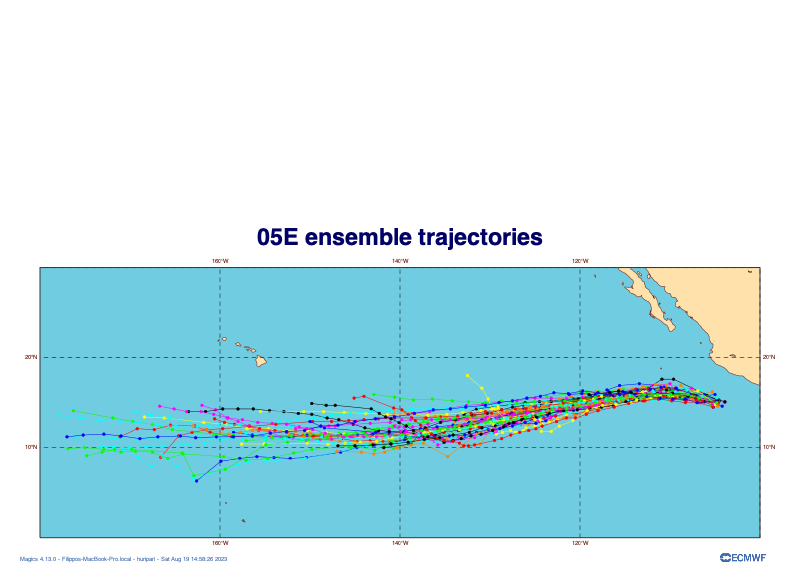

In [67]:
toplot = plot_ensemble_tracks('05E', 0, 30, -180, -100)
plot(toplot)

In [3]:
## TRACKS LIST CREATION ##
def create_tracks_list(df_tracks):
    
    storms = df_tracks.stormIdentifier.unique()
    cycls_tracks = []
    
    for storm in storms:
        df_cycl = df_tracks[df_tracks.stormIdentifier == storm]
        ensembles = df_cycl.ensembleMemberNumber.unique()
        
        cycl_tracks = []
        
        for ensemble in ensembles:
            df_track = df_cycl[df_cycl.ensembleMemberNumber == ensemble]
            
            lat = df_track.latitude.values
            lon = df_track.longitude.values
            locations = [[lat[i], lon[i]] for i in range(len(lat))]
            
            cycl_tracks.append(locations)
        
        cycls_tracks.append(cycl_tracks)

    return cycls_tracks

storms_tracks = create_tracks_list(df_storms)

In [4]:
## BASIC MAGICS COMMAND ##

# Setting of the PNG output
out1 = output(
            output_formats = ['png'],
            output_name = "magics",
            output_name_first_page_number = "off"
    )

# Settings of the coastlines attributes
coast = mcoast(
  map_coastline_land_shade = "on",
  map_coastline_land_shade_colour = "cream",
  map_grid_line_style = "dash",
  map_grid_colour = "brown",
  map_label_colour = "brown",
  map_coastline_colour = "brown"
)

# Settings of the text (notice the HTML formatting)
title = mtext(
  text_lines = ["Hello World!", " <b>This is my first plot</b> !"],
  text_font_size = "0.7",
  text_colour = "charcoal"
  )

# The plot command will create a PNG output called magics.png
plot(out1, coast, title)

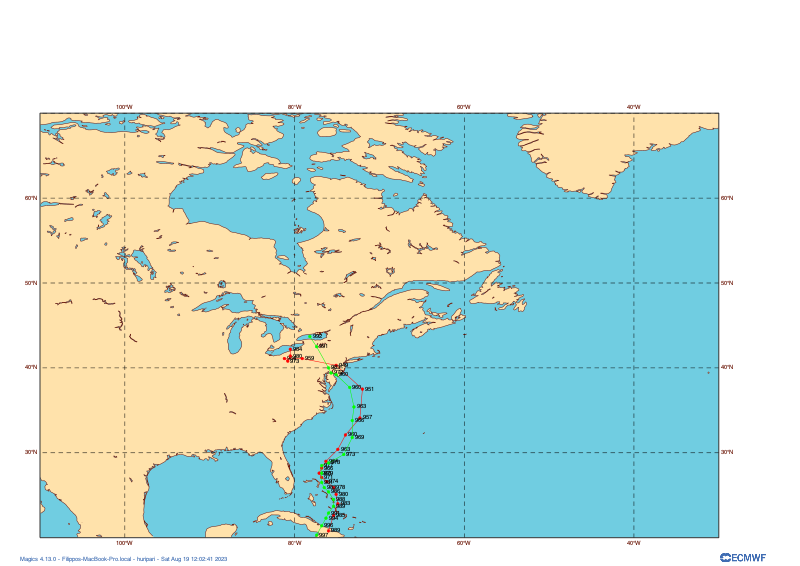

In [5]:
# setting the output
'''out1 = output(   
                output_formats = ['png'],
                output_name = "traj_step1",
                output_name_first_page_number = "off"
        )'''

# settings of the geographical area
area = mmap(
    subpage_map_projection="cylindrical",
    subpage_lower_left_longitude=-110.,
    subpage_lower_left_latitude=20.,
    subpage_upper_right_longitude=-30.,
    subpage_upper_right_latitude=70.,
)

# settings of the coastline, documentation -> https://confluence.ecmwf.int/display/MAGP/Coastlines
coast = mcoast(
    map_coastline_land_shade = "on",
    map_coastline_land_shade_colour = "cream",
    map_coastline_sea_shade = "on",
    map_coastline_sea_shade_colour = "#70CEE2",
    # map_cities = "on",
    map_grid_line_style = "dash",
    map_grid_colour = "black",
    map_label = "on",
    map_label_colour = "brown",
    map_coastline_colour = "brown",
)

# load the data
data1 = mtable(
    table_filename = "data/trajectories/trajectory_01.csv",
    table_variable_identifier_type='index',
    table_latitude_variable = "1",
    table_longitude_variable = "2",
    table_value_variable = "6",
    table_header_row = 0,
)

# define the sumbol plotting with connected
line1=msymb(
    symbol_type='both',
    symbol_marker_index = 28,
    symbol_colour = "red",
    symbol_height = 0.20,
    symbol_text_font_colour = "black",       
    symbol_connect_line ='on'
)

#Load the data
data2 = mtable(
    table_filename = "data/trajectories/trajectory_02.csv",
    table_variable_identifier_type='index',
    table_latitude_variable = "1",
    table_longitude_variable = "2",
    table_value_variable = "6",
    table_header_row = 0,
)

#Define the symbol plotting with connected
line2=msymb(
    symbol_type='both',
    symbol_marker_index = 28,
    symbol_colour = "green",
    symbol_height = 0.20,
    symbol_text_font_colour = "black",       
    symbol_connect_line ='on'
)

# print result
# plot(out1, area, coast)
plot(area, coast, data1, line1, data2, line2)

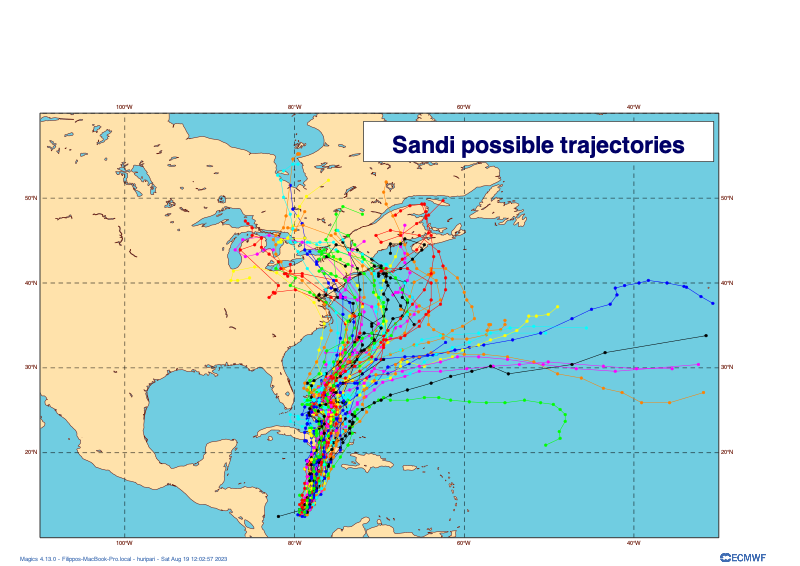

In [7]:
toplot = []
# settings of the geographical area
area = mmap(
    subpage_map_projection="cylindrical",
    subpage_lower_left_longitude=-110.,
    subpage_lower_left_latitude=10.,
    subpage_upper_right_longitude=-30.,
    subpage_upper_right_latitude=60.,
)
toplot.append(area)

# settings of the coastline, documentation -> https://confluence.ecmwf.int/display/MAGP/Coastlines
coast = mcoast(
    map_coastline_land_shade = "on",
    map_coastline_land_shade_colour = "cream",
    map_coastline_sea_shade = "on",
    map_coastline_sea_shade_colour = "#70CEE2",
    # map_cities = "on",
    map_grid_line_style = "dash",
    map_grid_colour = "black",
    map_label = "on",
    map_label_colour = "brown",
    map_coastline_colour = "brown",
)
toplot.append(coast)

colours = ["red", "blue", "green", "yellow", "purple", "orange", "cyan", "black" ]

colour = 0

for i in range(1,52):
    
    file = "data/trajectories/trajectory_%02d.csv" % i
    
    data = mtable(
        table_filename = file,
        table_variable_identifier_type='index',
        table_latitude_variable = "1",
        table_longitude_variable = "2",
        table_value_variable = "6",
        table_header_row = 0,
    )
    
    line=msymb(
        symbol_type='marker',
        symbol_marker_index = 28,
        symbol_colour = colours[colour],
        symbol_height = 0.20,
        symbol_text_font_colour = "black",       
        symbol_connect_line ='on'
    )
    
    colour += 1
    if colour == len(colours):
        colour = 0
        
    toplot.append(data)
    toplot.append(line)
    
title = mtext(
    text_lines= ["<font colour='navy'> Sandi possible trajectories </font>"],
    text_justification= 'centre',
    text_font_size= 1.,
    text_font_style= 'bold',
    text_box_blanking='on',
    text_border='on',
    text_mode='positional',
    text_box_x_position = 13.5,
    text_box_y_position = 15.,
    text_box_x_length = 13.,
    text_box_y_length = 1.5,
    text_border_colour='charcoal'
)
toplot.append(title)

plot(toplot)